In [62]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [63]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
#     print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [64]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(abdul_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [65]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [66]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [67]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [68]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [69]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [70]:
master_data = master_data[132:]

In [71]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [72]:
master_data.reset_index(inplace=True)

In [73]:
master_data = master_data.drop(labels='index', axis=1)

In [74]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


In [75]:
# type(data_copy['date'])
# # data_copy['date'].astype(p)

<h2>Load Covariate Data and Concat to Master_Data</h2>

In [76]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [77]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(abdul_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [78]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [79]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [80]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [81]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [82]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [83]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [84]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_cov_set(ismael_path_pdo)
# pdo_data

In [85]:
# master_data = data_copy

In [86]:
# pdo = pdo_data["PDO"]
# pdo = pdo[:984]
# pdo
# master_data = master_data.join(pdo)
# # master_data
# # master_data = master_data[:984]
# # master_data = master_data.reindex(columns=["Date", "Month", "king", "PDO"])
# # master_data

In [87]:
# # master_data.columns = ['year', 'month', 'king', 'pdo']
# master_data

In [88]:
# master_data

In [89]:
# master_data['year']=pd.to_datetime(master_data[['year','month']])
# master_data.set_index('date', inplace=True)
# master_data.index = pd.to_datetime(master_data.index)
# master_data

<h2> Load and Concat NOI data </h2>

In [90]:
# ismael_path_noi = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/noi.csv'
# noi_data = load_cov_set(ismael_path_noi)
# noi_data = noi_data[:877]
# noi_data = noi_data.drop(labels=0, axis=0)
# noi_data.reset_index()
# print(noi_data)
# print(noi_data['noix'])
# # noi_data = noi_data.drop(columns="index")

In [91]:
# noi = noi_data["noix"]
# # noi
# print(master_data)
# master_data = master_data[120:]
# print(master_data)
# master_data.reset_index()
# master_data = master_data.join(noi)

In [92]:
# master_data = master_data.reset_index()

In [93]:
# master_data
# master_data = master_data.drop(labels="index", axis=1)

In [94]:
# master_data.head(700)

In [95]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [96]:
master_data.to_csv('master_data.csv')

In [97]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=abdul_checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

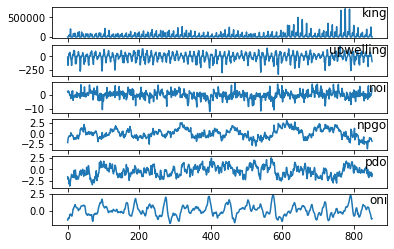

In [98]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [99]:
# convert series to supervised learning
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [100]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [101]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [102]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
1/1 - 11s - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2189
Epoch 2/1000
1/1 - 0s - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0462 - val_root_mean_squared_error: 0.2149
Epoch 3/1000
1/1 - 0s - loss: 0.0103 - root_mean_squared_error: 0.1017 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2112
Epoch 4/1000
1/1 - 0s - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0432 - val_root_mean_squared_error: 0.2079
Epoch 5/1000
1/1 - 0s - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2051
Epoch 6/1000
1/1 - 0s - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2028
Epoch 7/1000
1/1 - 0s - loss: 0.0094 - root_mean_squared_error: 0.0967 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2014
Epoch 8/1000
1/1 - 0s - loss: 0.0095 - root_mean_squared_error: 0.0974 - val_loss: 0.0402 - val_root_me

Epoch 40/1000
1/1 - 0s - loss: 0.0092 - root_mean_squared_error: 0.0957 - val_loss: 0.0415 - val_root_mean_squared_error: 0.2038
Epoch 41/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0416 - val_root_mean_squared_error: 0.2040
Epoch 42/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 43/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2044
Epoch 44/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0956 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2045
Epoch 45/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0418 - val_root_mean_squared_error: 0.2044
Epoch 46/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2043
Epoch 47/1000
1/1 - 0s - loss: 0.0091 - root_mean_squared_error: 0.0954 - val_loss: 0.0417 - val_

Epoch 79/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0935 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 80/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2009
Epoch 81/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2009
Epoch 82/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0933 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 83/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2011
Epoch 84/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0932 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2010
Epoch 85/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0403 - val_root_mean_squared_error: 0.2008
Epoch 86/1000
1/1 - 0s - loss: 0.0087 - root_mean_squared_error: 0.0931 - val_loss: 0.0402 - val_

Epoch 118/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1968
Epoch 119/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1966
Epoch 120/1000
1/1 - 0s - loss: 0.0082 - root_mean_squared_error: 0.0903 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1963
Epoch 121/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 122/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1956
Epoch 123/1000
1/1 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1952
Epoch 124/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0896 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1947
Epoch 125/1000
1/1 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.037

Epoch 157/1000
1/1 - 0s - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1723
Epoch 158/1000
1/1 - 0s - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1712
Epoch 159/1000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0283 - val_root_mean_squared_error: 0.1682
Epoch 160/1000
1/1 - 0s - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1677
Epoch 161/1000
1/1 - 0s - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1671
Epoch 162/1000
1/1 - 0s - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1646
Epoch 163/1000
1/1 - 0s - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1644
Epoch 164/1000
1/1 - 0s - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.026

Epoch 196/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1444
Epoch 197/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1446
Epoch 198/1000
1/1 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1434
Epoch 199/1000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0695 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433
Epoch 200/1000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0693 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1428
Epoch 201/1000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0692 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1423
Epoch 202/1000
1/1 - 0s - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1416
Epoch 203/1000
1/1 - 0s - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.020

Epoch 235/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0650 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1312
Epoch 236/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 237/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0648 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 238/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1294
Epoch 239/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1292
Epoch 240/1000
1/1 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0644 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1257
Epoch 241/1000
1/1 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1284
Epoch 242/1000
1/1 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0642 - val_loss: 0.016

Epoch 274/1000
1/1 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 275/1000
1/1 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 276/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 277/1000
1/1 - 0s - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 278/1000
1/1 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 279/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 280/1000
1/1 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 281/1000
1/1 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.013

Epoch 313/1000
1/1 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 314/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 315/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 316/1000
1/1 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0588 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 317/1000
1/1 - 0s - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1022
Epoch 318/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0985
Epoch 319/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 320/1000
1/1 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0585 - val_loss: 0.011

Epoch 352/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0872
Epoch 353/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 354/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 355/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 356/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0526 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0869
Epoch 357/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0526 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 358/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 359/1000
1/1 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.007

Epoch 391/1000
1/1 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0961
Epoch 392/1000
1/1 - 0s - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0828
Epoch 393/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 394/1000
1/1 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 395/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 396/1000
1/1 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 397/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0539 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0924
Epoch 398/1000
1/1 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.007

Epoch 430/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 431/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0768
Epoch 432/1000
1/1 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 433/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0767
Epoch 434/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0503 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0757
Epoch 435/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 436/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 437/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.006

Epoch 469/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 470/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 471/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 472/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 473/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0719
Epoch 474/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 475/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 476/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.005

Epoch 508/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671
Epoch 509/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670
Epoch 510/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 511/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0668
Epoch 512/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 513/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 514/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 515/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.004

Epoch 547/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0632
Epoch 548/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0636
Epoch 549/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 550/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 551/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0717
Epoch 552/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 553/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 554/1000
1/1 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.004

Epoch 586/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 587/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 588/1000
1/1 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 589/1000
1/1 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0722
Epoch 590/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 591/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 592/1000
1/1 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 593/1000
1/1 - 0s - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.004

Epoch 625/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 626/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 627/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 628/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 629/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 630/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 631/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 632/1000
1/1 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.003

Epoch 664/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 665/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 666/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 667/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 668/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561
Epoch 669/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 670/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 671/1000
1/1 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.003

Epoch 703/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 704/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 705/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 706/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 707/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 708/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 709/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 710/1000
1/1 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.003

Epoch 742/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 743/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 744/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 745/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 746/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 747/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 748/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 749/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.002

Epoch 781/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 782/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 783/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 784/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 785/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 786/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 787/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 788/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.002

Epoch 820/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 821/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 822/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 823/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 824/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 825/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 826/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 827/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.002

Epoch 859/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 860/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 861/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 862/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 863/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 864/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 865/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 866/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.002

Epoch 898/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 899/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 900/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 901/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 902/1000
1/1 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 903/1000
1/1 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0367 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 904/1000
1/1 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 905/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.003

Epoch 937/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 938/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 939/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 940/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 941/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 942/1000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 943/1000
1/1 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 944/1000
1/1 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.002

Epoch 975/1000
1/1 - 0s - loss: 9.7732e-04 - root_mean_squared_error: 0.0313 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 976/1000
1/1 - 0s - loss: 9.7487e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 977/1000
1/1 - 0s - loss: 9.7390e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 978/1000
1/1 - 0s - loss: 9.7169e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 979/1000
1/1 - 0s - loss: 9.7033e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 980/1000
1/1 - 0s - loss: 9.6909e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 981/1000
1/1 - 0s - loss: 9.6702e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 982/1000
1/1 - 0s - loss: 9.6580e-04 - root_mean_squared

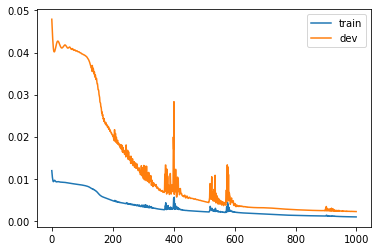

In [103]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=1000, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [104]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [105]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [106]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [107]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

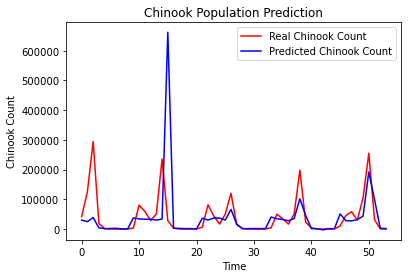

The test root mean squared error is 101646.89563385594.


In [108]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

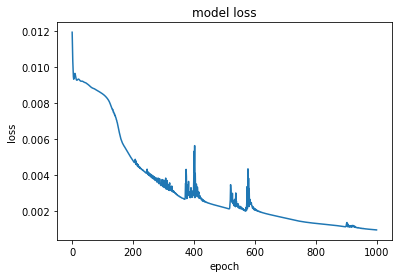

In [109]:
plot_loss(history)

In [110]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  871577
1  259078
2  325744
3  475728
    Count
0  488981
1  336030
2  381773
3  535746


In [111]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_abdul_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [112]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [113]:
return_rmse(actual, preds)

The test root mean squared error is 199400.80158126247.


In [114]:
# def create_train_test(king_all):
#     king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
#     king_training = king_all[king_training_parse]
#     king_training = king_training.reset_index()
#     king_training = king_training.drop('index', axis=1)
    
#     king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
#     king_test = king_all[king_test_parse]
#     king_test = king_test.reset_index()
#     king_test = king_test.drop('index', axis=1)
#     print(king_test.shape)
    
#     # Normalizing Data
#     king_training[king_training["king"] < 0] = 0 
# #     print('max val king_train:')
#     print(max(king_training['king']))
#     king_test[king_test["king"] < 0] = 0
# #     print('max val king_test:')
#     print(max(king_test['king']))
#     king_train_pre = king_training["king"].to_frame()
# #     print(king_train_norm)
#     king_test_pre = king_test["king"].to_frame()
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     king_train_norm = scaler.fit_transform(king_train_pre)
#     king_test_norm = scaler.fit_transform(king_test_pre)
#     print('king_test_norm')
#     print(king_test_norm.shape)
#     print('king_train_norm')
#     print(king_train_norm.shape)
#     #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
#     #print(type(king_train_norm))
#     #king_train_norm = king_train_norm.to_frame()
#     x_train = []
#     y_train = []
#     x_test = []
#     y_test = []
#     y_test_not_norm = []
#     y_train_not_norm = []
    
#     # Todo: Experiment with input size of input (ex. 30 days)
    
#     for i in range(6,924): # 30
#         x_train.append(king_train_norm[i-6:i])
#         y_train.append(king_train_norm[i])
#     for i in range(6, 60):
#         x_test.append(king_test_norm[i-6:i])
#         y_test.append(king_test_norm[i])
    
#     # make y_test_not_norm
#     for i in range(6, 60):
#         y_test_not_norm.append(king_test['king'][i])
#     for i in range(6,924): # 30
#         y_train_not_norm.append(king_training['king'][i])
        
#     return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [115]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)


NameError: name 'create_train_test' is not defined

In [ ]:
# def load_pdo(pathname):
#     pdo_data = pd.read_csv(pathname)
# #     print(pdo_data.head())
#     return pdo_data

In [ ]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_pdo(ismael_path_pdo)

In [ ]:
# pdo = pdo_data["PDO"]
# data_copy = data_copy.join(pdo)

In [ ]:
# pdo_data

In [ ]:
# print(data_copy)